# Projetc - german credit risk

In [107]:
import requests
import logging
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

In [108]:
DATA_DIR = Path.cwd().parent / 'data'
DATA_DIR

PosixPath('/home/victor/insper/6-sem/ml/german-credit-classifier/data')

In [109]:
def load_data(data_dir: Path = DATA_DIR) -> pd.DataFrame:
    pickle_file_path = data_dir / 'data.pkl'
    if not pickle_file_path.exists():
        data_dir.mkdir(parents=True, exist_ok=True)

        url = 'https://archive.ics.uci.edu/static/public/144/statlog+german+credit+data.zip'
        response = requests.get(url)
        if response.status_code != 200:
            logging.info('Failed to download dataset.')
            return None

        file_path = data_dir / 'data.zip'
        with open(file_path, 'wb') as file:
            file.write(response.content)
        logging.info('Dataset downloaded successfully.')

        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall(path=data_dir)

        columns = [
            'status',
            'duration',
            'history',
            'purpose',
            'amount',
            'savings',
            'employment',
            'installment',
            'status_sex',
            'guarantors',
            'residence',
            'property_type',
            'age',
            'plans',
            'housing',
            'credits',
            'job',
            'dependents',
            'telephone',
            'foreign',
            'target',
        ]
        data = pd.read_csv(
            data_dir / 'german.data',
            sep=' ', 
            header=None, 
            names=columns,
        )

        data.to_pickle(pickle_file_path)
    else:
        data = pd.read_pickle(pickle_file_path)

    return data

In [110]:
df = load_data()
df.head()

,status,duration,history,purpose,amount,savings,employment,installment,status_sex,guarantors,...,property_type,age,plans,housing,credits,job,dependents,telephone,foreign,target
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   status         1000 non-null   object
 1   duration       1000 non-null   int64 
 2   history        1000 non-null   object
 3   purpose        1000 non-null   object
 4   amount         1000 non-null   int64 
 5   savings        1000 non-null   object
 6   employment     1000 non-null   object
 7   installment    1000 non-null   int64 
 8   status_sex     1000 non-null   object
 9   guarantors     1000 non-null   object
 10  residence      1000 non-null   int64 
 11  property_type  1000 non-null   object
 12  age            1000 non-null   int64 
 13  plans          1000 non-null   object
 14  housing        1000 non-null   object
 15  credits        1000 non-null   int64 
 16  job            1000 non-null   object
 17  dependents     1000 non-null   int64 
 18  telephone      1000 non-null 

In [112]:
# Define mapping dictionaries for all categorical attributes
attribute_mappings = {
    'status': {
        'A11': '< 0 DM',
        'A12': '0 <= ... < 200 DM',
        'A13': '>= 200 DM / salary assignments for at least 1 year',
        'A14': 'no checking account'
    },
    'history': {
        'A30': 'no credits taken/ all credits paid back duly',
        'A31': 'all credits at this bank paid back duly',
        'A32': 'existing credits paid back duly till now',
        'A33': 'delay in paying off in the past',
        'A34': 'critical account/ other credits existing (not at this bank)'
    },
    'purpose': {
        'A40': 'car (new)',
        'A41': 'car (used)',
        'A42': 'furniture/equipment',
        'A43': 'radio/television',
        'A44': 'domestic appliances',
        'A45': 'repairs',
        'A46': 'education',
        'A47': '(vacation - does not exist?)',
        'A48': 'retraining',
        'A49': 'business',
        'A410': 'others'
    },
    'savings': {
        'A61': '... < 100 DM',
        'A62': '100 <= ... < 500 DM',
        'A63': '500 <= ... < 1000 DM',
        'A64': '>= 1000 DM',
        'A65': 'unknown/ no savings account'
    },
    'employment': {
        'A71': 'unemployed',
        'A72': '< 1 year',
        'A73': '1 <= ... < 4 years',
        'A74': '4 <= ... < 7 years',
        'A75': '>= 7 years'
    },
    'status_sex': {
        'A91': 'male : divorced/separated',
        'A92': 'female : divorced/separated/married',
        'A93': 'male : single',
        'A94': 'male : married/widowed'
    },
    'guarantors': {
        'A101': 'none',
        'A102': 'co-applicant',
        'A103': 'guarantor'
    },
    'property_type': {
        'A121': 'real estate',
        'A122': 'building society savings agreement/ life insurance',
        'A123': 'car or other, not in attribute 6',
        'A124': 'unknown / no property'
    },
    'plans': {
        'A141': 'bank',
        'A142': 'stores',
        'A143': 'none'
    },
    'housing': {
        'A151': 'rent',
        'A152': 'own',
        'A153': 'for free'
    },
    'job': {
        'A171': 'unemployed/ unskilled - non-resident',
        'A172': 'unskilled - resident',
        'A173': 'skilled employee/official',
        'A174': 'management/self-employed/highly qualified employee/officer'
    },
    'telephone': {
        'A191': 'none',
        'A192': 'yes, registered under the customer\'s name'
    },
    'foreign': {
        'A201': 'yes',
        'A202': 'no'
    }
}

# Iterate through categorical columns and apply mappings
categorical_columns = list(attribute_mappings.keys())

for column in categorical_columns:
    if column in df.columns:
        df[column] = df[column].map(attribute_mappings[column])


## Stratified spliting between train and test

In [113]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [114]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)
for train_index, test_index in split.split(df, df.target):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

## Exploring train set

### Numerical data

In [115]:
numeric_df = strat_train_set.select_dtypes(include=['float64', 'int64'])
categ_df = strat_train_set.select_dtypes(include=['object'])

In [116]:
corr_matrix = numeric_df.corr(method='pearson')
corr_matrix['target'].sort_values(ascending=False)

target         1.000000
duration       0.206301
amount         0.138776
installment    0.080345
dependents     0.011905
residence      0.001965
credits       -0.047149
age           -0.057750
Name: target, dtype: float64

In [117]:
strat_train_set.describe()

,duration,amount,installment,residence,age,credits,dependents,target
count,800.000000,800.00000,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000
mean,20.770000,3189.59125,2.941250,2.83000,35.323750,1.407500,1.160000,1.300000
std,11.817325,2673.54737,1.124446,1.11137,11.045313,0.567315,0.366835,0.458544
min,4.000000,276.00000,1.000000,1.00000,19.000000,1.000000,1.000000,1.000000
25%,12.000000,1353.00000,2.000000,2.00000,27.000000,1.000000,1.000000,1.000000
50%,18.000000,2317.00000,3.000000,3.00000,33.000000,1.000000,1.000000,1.000000
75%,24.000000,3933.00000,4.000000,4.00000,41.000000,2.000000,1.000000,2.000000
max,60.000000,15945.00000,4.000000,4.00000,75.000000,4.000000,2.000000,2.000000


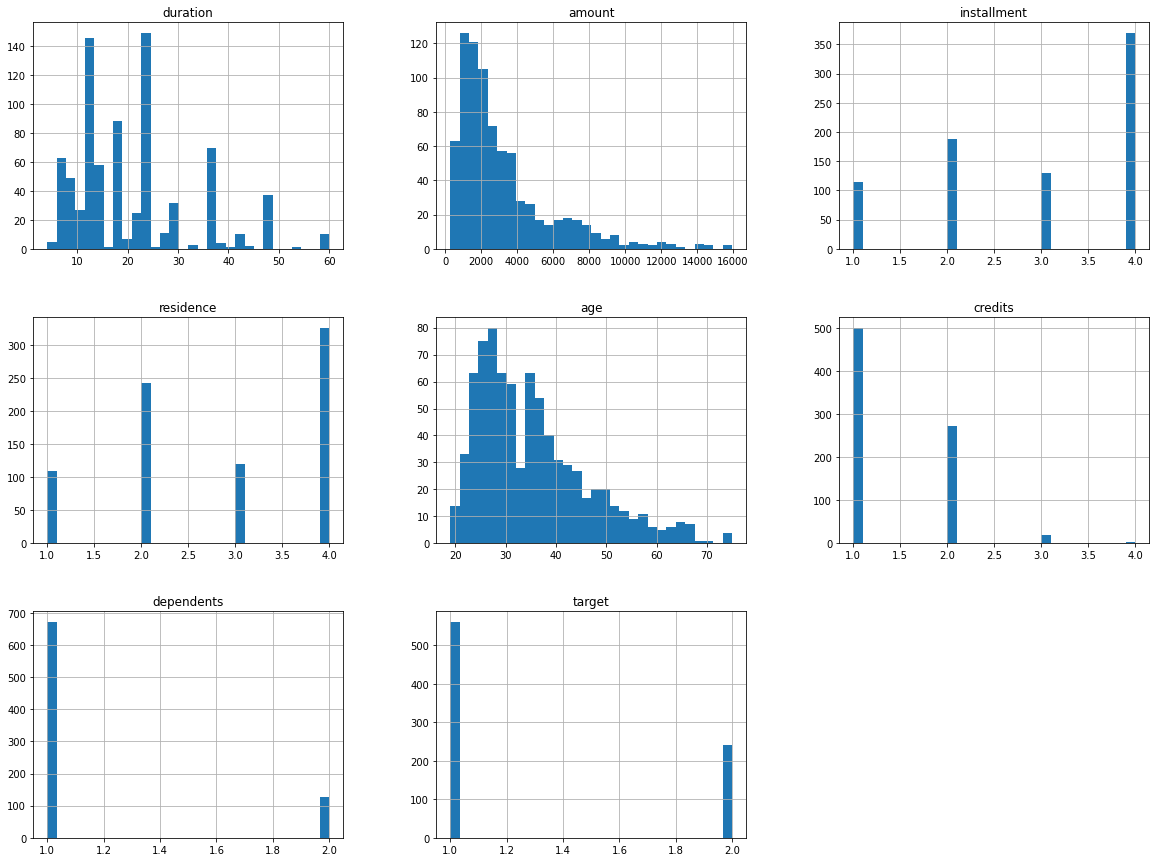

In [118]:
strat_train_set.hist(bins=30, figsize=(20,15))
plt.show()

### Categorical data

In [119]:
for column in categ_df.columns:
    value_counts = strat_train_set[column].value_counts()
    print("----------------------------------------------------------------")
    print(f"Value counts for column '{column}':\n{value_counts}\n")

----------------------------------------------------------------
Value counts for column 'status':
status
no checking account                                   316
< 0 DM                                                219
0 <= ... < 200 DM                                     214
>= 200 DM / salary assignments for at least 1 year     51
Name: count, dtype: int64

----------------------------------------------------------------
Value counts for column 'history':
history
existing credits paid back duly till now                       416
critical account/ other credits existing (not at this bank)    240
delay in paying off in the past                                 72
all credits at this bank paid back duly                         41
no credits taken/ all credits paid back duly                    31
Name: count, dtype: int64

----------------------------------------------------------------
Value counts for column 'purpose':
purpose
radio/television       215
car (new)              194
fur

## Separating X and y

In [123]:
y_target = strat_train_set['target'].copy()
X_data = strat_train_set.drop('target', axis=19)

ValueError: No axis named 19 for object type DataFrame